# Classical Simulation of Quantum Circuits

Performing a quantum computation (commonly described as a quantum circuit) entails evolving an initial quantum state by applying a sequence of operations (also called gates) and measuring the resulting system.
Eventually, the goal should obviously be to do that on a real device.
However, there are several important reasons for simulating the corresponding computations on a classical machine, particularly in the early stages of the design:
As long as no suitable devices are available (e.g., in terms of scale, feasible computation depth, or accuracy), classical simulations of quantum circuits still allow one to explore and test quantum applications, even if only on a limited scale.
However, also with further progress in the capabilities of the hardware platforms, classical simulation will remain an essential part of the quantum computing design process, since it additionally allows access to _all_ amplitudes of a resulting quantum state in contrast to a real device that only probabilistically returns measurement results.
Moreover, classical simulation provides means to study quantum error correction as well as a baseline to estimate the advantage of quantum computers over classical computers.

The classical simulation of quantum circuits is commonly conducted by performing consecutive matrix-vector multiplication, which many simulators realize by storing a dense representation of the complete state vector in memory and evolving it correspondingly or by relying on tensor network methods.
This approach quickly becomes intractable due to the exponential growth of the quantum state with respect to the number of qubits---quickly rendering such simulations infeasible even on supercomputer clusters.
Simulation methodologies based on decision diagrams are a promising complementary approach that frequently allows reducing the required memory by exploiting redundancies in the simulated quantum state.

The _MQT_ offers the classical quantum circuit simulator _DDSIM_ that can be used to perform various quantum circuit simulation tasks based on using decision diagrams as a data structure.
This includes strong and weak simulation, approximation techniques, noise-aware simulation, hybrid Schrödinger-Feynman techniques, support for dynamic circuits, the computation of expectation values, the simulation of mixed-dimensional systems, and more.

In the following, we will use IBM's Qiskit to define quantum circuits and then simulate them using the MQT DDSIM simulator and IBM's Aer simulator.

## Simulating Simple Quantum Gates

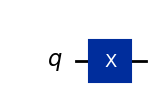

In [2]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(1)
circ.x(0)
circ.draw(output="mpl")

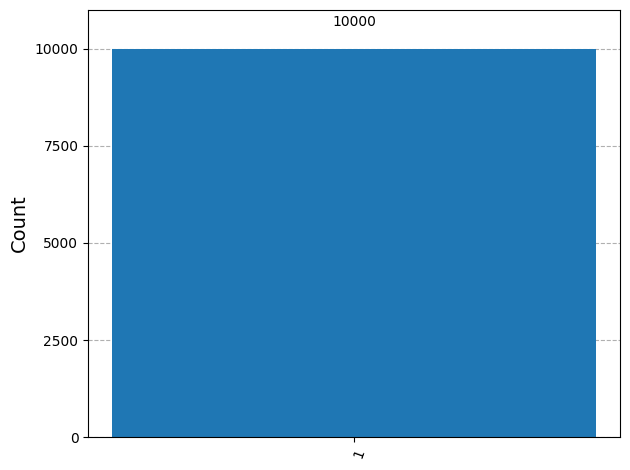

In [3]:
from mqt.ddsim import DDSIMProvider
from qiskit.visualization import plot_histogram

provider = DDSIMProvider()
backend = provider.get_backend("qasm_simulator")
result = backend.run(circ, shots=10000).result()
plot_histogram(result.get_counts())

## Simulating a CNOT gate

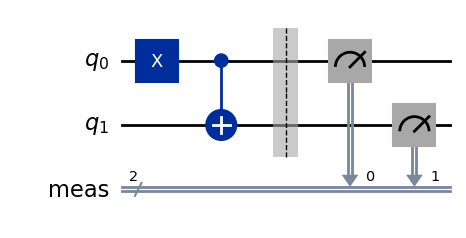

In [4]:
circ = QuantumCircuit(2)
circ.x(0)
circ.cx(0,1)
circ.measure_all()
circ.draw(output="mpl")

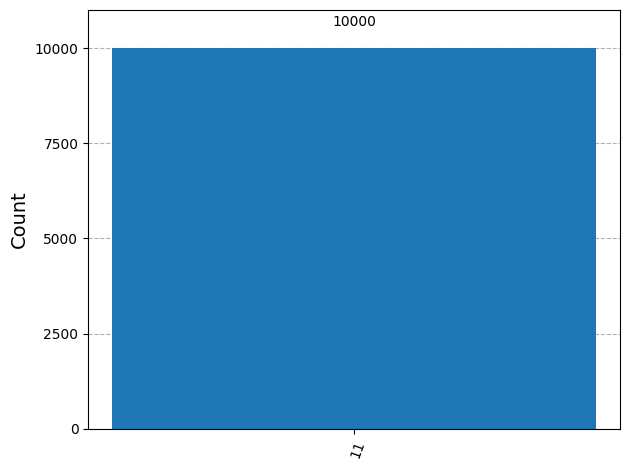

In [5]:
result = backend.run(circ, shots=10000).result()
plot_histogram(result.get_counts())

## Simulating a Hadamard Gate and a Bell State

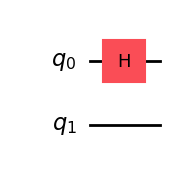

In [6]:
circ = QuantumCircuit(2)
circ.h(0)
circ.draw(output="mpl")

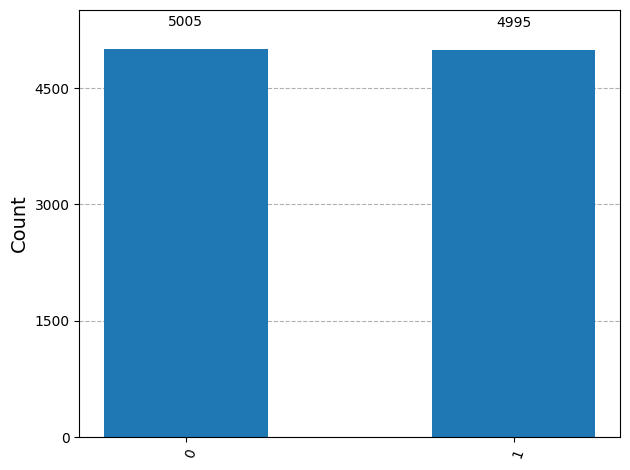

In [7]:
result = backend.run(circ, shots=10000).result()
plot_histogram(result.get_counts())

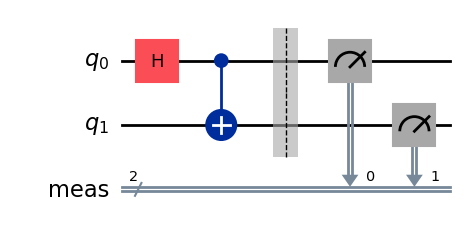

In [8]:
circ.cx(0,1)
circ.measure_all()
circ.draw(output="mpl")

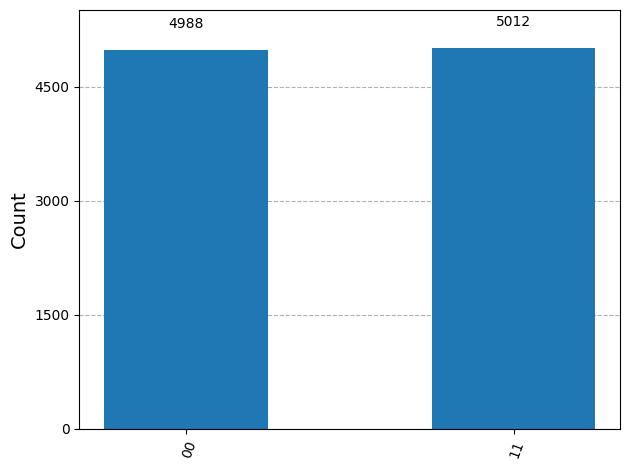

In [9]:
result = backend.run(circ, shots=10000).result()
plot_histogram(result.get_counts())

## Simulating a GHZ State

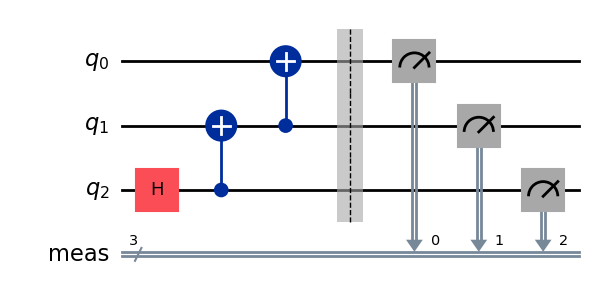

In [10]:
circ = QuantumCircuit(3)
circ.h(2)
circ.cx(2, 1)
circ.cx(1, 0)
circ.measure_all()
circ.draw(output="mpl")

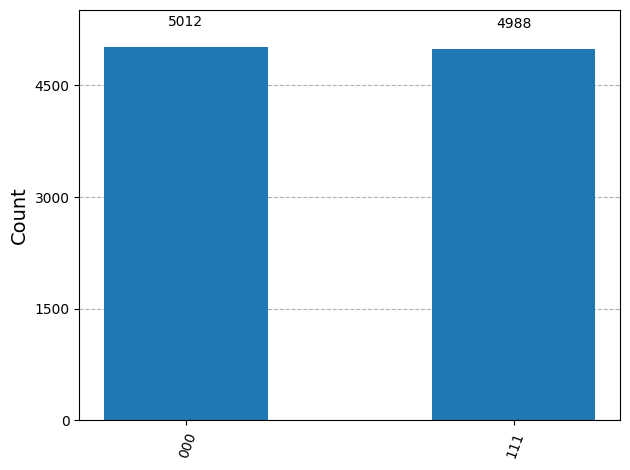

In [11]:
result = backend.run(circ, shots=10000).result()
plot_histogram(result.get_counts())

# MQT Bench

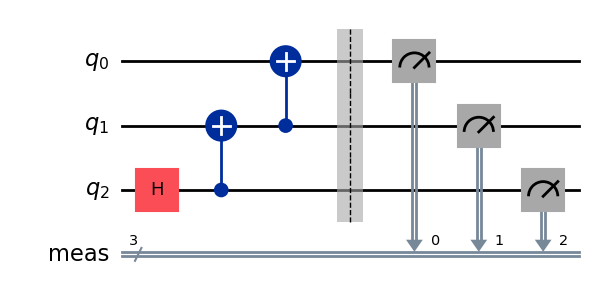

In [12]:
from mqt.bench import get_benchmark, BenchmarkLevel

circ = get_benchmark(benchmark="ghz", level=BenchmarkLevel.ALG, circuit_size=3)
circ.draw(output="mpl")

## Select a 5 qubit Quantum Phase Estimation (QPE) circuit and simulate it using DDSIM.

MQT Bench GitHub: https://github.com/cda-tum/mqt-bench

Documentation: https://mqt.readthedocs.io/projects/bench/en/latest/Benchmark_selection.html

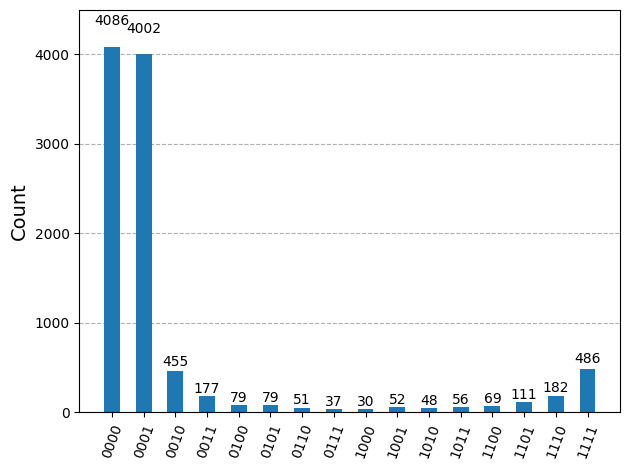

In [13]:
from mqt.bench import get_benchmark

circ = get_benchmark(benchmark="qpeinexact", level=BenchmarkLevel.ALG, circuit_size=5)
circ.draw(output="mpl")

result = backend.run(circ, shots=10000).result()
plot_histogram(result.get_counts())

## Evaluating the Runtime for a Qiskit Statevector Simulator

In [22]:
from qiskit.primitives import StatevectorSampler
import time

sampler = StatevectorSampler()
runtimes = []
value_range = range(10, 25, 2)
for i in value_range:
    circ = get_benchmark(benchmark="ghz", level=BenchmarkLevel.ALG, circuit_size=i)
    circ.measure_all()
    
    start = time.time()
    job = sampler.run([circ], shots=10000)
    result = job.result()
    runtime = time.time() - start
    
    runtimes.append(runtime)
    print(f"GHZ-{i}: {runtime:.6f}s")

GHZ-10: 0.032364s
GHZ-12: 0.033798s
GHZ-14: 0.073366s
GHZ-16: 0.309804s
GHZ-18: 1.637052s
GHZ-20: 9.452711s
GHZ-22: 45.945422s
GHZ-24: 222.598600s


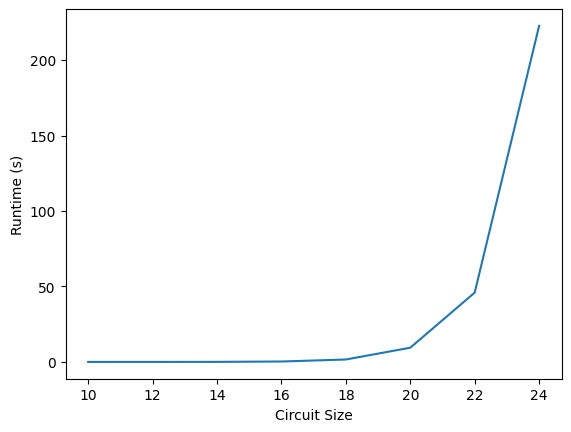

In [23]:
import matplotlib.pyplot as plt
plt.xlabel("Circuit Size")
plt.ylabel("Runtime (s)")
plt.plot(value_range, runtimes)

## Evaluating the Runtime for the DDSim Simulator

GHZ-10: 0.15989279747009277
GHZ-12: 0.20618700981140137
GHZ-14: 0.2650182247161865
GHZ-16: 0.35427212715148926
GHZ-18: 0.4228072166442871
GHZ-20: 0.5050568580627441
GHZ-22: 0.5320520401000977
GHZ-24: 0.682415246963501


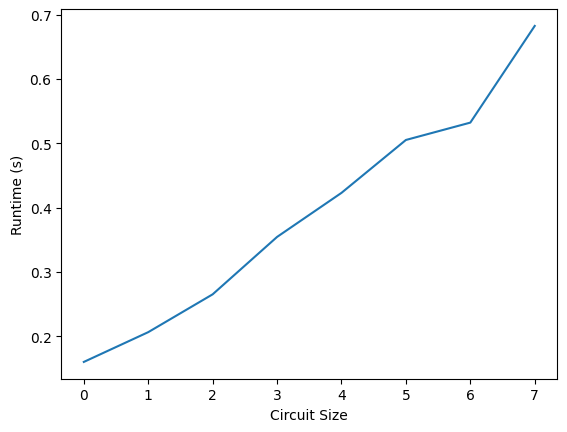

In [24]:
backend = provider.get_backend("qasm_simulator")
runtimes_ddsim = []
for i in value_range:
    circ = get_benchmark(benchmark="ghz", level=BenchmarkLevel.ALG, circuit_size=i)
    circ.measure_all()
    result = backend.run(circ, shots=10000).result()
    runtimes_ddsim.append(result.time_taken)
    print(f"GHZ-{i}: {result.time_taken}")
    
plt.xlabel("Circuit Size")
plt.ylabel("Runtime (s)")
plt.plot(runtimes_ddsim)

## Direct Comparison

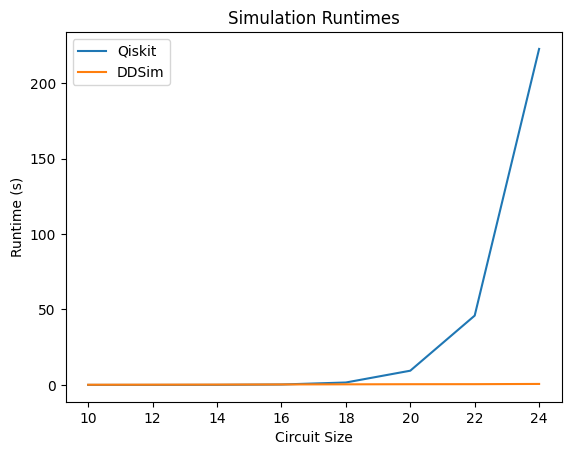

In [25]:
plt.xlabel("Circuit Size")
plt.ylabel("Runtime (s)")
plt.title("Simulation Runtimes")
plt.plot(value_range, runtimes, label="Qiskit")
plt.plot(value_range, runtimes_ddsim, label="DDSim")
plt.legend()

## Inspiration for further tasks:

- Choose different algorithms from MQT Bench
- Use other Qiskit simulation primitives (see https://docs.quantum.ibm.com/api/qiskit/primitives)
- Use other MQT DDSim simulation methods (see https://mqt.readthedocs.io/projects/ddsim/en/latest/Simulators.html)